In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq
import numpy as np
import cirq
from qcircuits.QCircuit import QCircuit
import sys,yaml
from tools.tools import *
from test import test
import cirq
from cirq.contrib.svg import SVGCircuit
import sympy

sys.path.insert(0, '/Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking')

###############################################################################
class Rescale01(tf.keras.layers.Layer):
    def __init__(self, name='Rescale01'):
        super(Rescale01, self).__init__(name=name)

    def call(self, X):
        X = tf.divide(
                tf.subtract(
                    X, 
                    tf.reduce_min(X)
                ), 
                tf.subtract(
                    tf.reduce_max(X), 
                    tf.reduce_min(X)
                ),
            lambda: X
        )
        return X
###############################################################################
class EdgeNet(tf.keras.layers.Layer):
    def __init__(self, name='EdgeNet'):
        super(EdgeNet, self).__init__(name=name)

        self.n_layers = GNN.config['EN_qc']['n_layers']
        self.n_qubits = GNN.config['EN_qc']['n_qubits']

        if 'dp_noise' in GNN.config['EN_qc'].keys():
            dp_noise = GNN.config['EN_qc']['dp_noise']
        else:
            # set noise to None if not specified 
            dp_noise = None
                
        # Read the Quantum Circuit with specified configuration
        qc = QCircuit(IEC_id=GNN.config['EN_qc']['IEC_id'],
            PQC_id=GNN.config['EN_qc']['PQC_id'],
            MC_id=GNN.config['EN_qc']['MC_id'],
            n_layers=self.n_layers, 
            input_size=self.n_qubits,
            p=0.01)
        
        self.model_circuit, self.qubits = qc.model_circuit()
        self.measurement_operators = qc.measurement_operators()

        # Prepare symbol list for inputs and parameters of the Quantum Circuits
        self.symbol_names = ['x{}'.format(i) for i in range(qc.n_inputs)]
        for i in range(qc.n_params):
            self.symbol_names.append('theta{}'.format(i)) 

        # Classical input layer of the Node Network
        # takes input data and feeds it to the PQC layer
        self.input_layer = tf.keras.Sequential([
            tf.keras.layers.Dense(
                self.n_qubits, 
                activation='relu'),
            Rescale01()
        ])
        
        # Prepare PQC layer
        if (dp_noise!=None):
            # Noisy simulation requires density matrix simulator
            self.exp_layer = tfq.layers.SampledExpectation(
                cirq.DensityMatrixSimulator(noise=cirq.depolarize(dp_noise))
            )
        elif dp_noise==None and GNN.config['EN_qc']['repetitions']!=0:
            # Use default simulator for noiseless execution
            self.exp_layer = tfq.layers.SampledExpectation()
        elif dp_noise==None and GNN.config['EN_qc']['repetitions']==0:
            # Use default simulator for noiseless execution
            self.exp_layer = tfq.layers.Expectation()
        else: 
            raise ValueError('Wrong PQC Specifications!')

         # Classical readout layer
        self.readout_layer = tf.keras.layers.Dense(1, activation='sigmoid')

        # Initialize parameters of the PQC
        self.params = tf.Variable(tf.random.uniform(
            shape=(1,qc.n_params),
            minval=0, maxval=1)*2*np.pi
        ) 

    def call(self,X, Ri, Ro):
        '''forward pass of the edge network. '''

        # Constrcu the B matrix
        bo = tf.matmul(Ro,X,transpose_a=True)
        bi = tf.matmul(Ri,X,transpose_a=True)
        # Shape of B = N_edges x 6 (2x (3 + Hidden Dimension Size))
        # each row consists of two node that are connected in the input graph.
        B  = tf.concat([bo, bi], axis=1) # n_edges x 6, 3-> r,phi,z 

        # Scale the output to be [0,PI]
        # this value is a preference and can be changed 
        # to do: add the scaling as a configuration input
        input_to_circuit = self.input_layer(B) * np.pi

        # Combine input data with parameters in a single circuit_data matrix
        circuit_data = tf.concat(
            [
                input_to_circuit, 
                tf.repeat(self.params,repeats=input_to_circuit.shape[0],axis=0)
            ],
            axis=1
        )        
          
        # Get expectation values for all edges
        if GNN.config['EN_qc']['repetitions']==0:
            exps = self.exp_layer(
                self.model_circuit,
                operators=self.measurement_operators,
                symbol_names=self.symbol_names,
                symbol_values=circuit_data
            )
        else:
            exps = self.exp_layer(
                self.model_circuit,
                operators=self.measurement_operators,
                symbol_names=self.symbol_names,
                symbol_values=circuit_data,
                repetitions=GNN.config['EN_qc']['repetitions']
            )
    
        # Return the output of the final layer
        return self.readout_layer(exps)

class NodeNet(tf.keras.layers.Layer):
    def __init__(self, name='NodeNet'):
        super(NodeNet, self).__init__(name=name)
        
        self.n_layers = GNN.config['NN_qc']['n_layers']
        self.n_qubits = GNN.config['NN_qc']['n_qubits']

        if 'dp_noise' in GNN.config['EN_qc'].keys():
            dp_noise = GNN.config['EN_qc']['dp_noise']
        else:
            # set noise to None if not specified 
            dp_noise = None
        
        # Read the Quantum Circuit with specified configuration
        qc = QCircuit(
            IEC_id=GNN.config['NN_qc']['IEC_id'],
            PQC_id=GNN.config['NN_qc']['PQC_id'],
            MC_id=GNN.config['NN_qc']['MC_id'],
            n_layers=self.n_layers, 
            input_size=self.n_qubits,
            p=0.01
        )
        self.model_circuit, self.qubits = qc.model_circuit()
        self.measurement_operators = qc.measurement_operators()

        # Prepare symbol list for inputs and parameters of the Quantum Circuits
        self.symbol_names = ['x{}'.format(i) for i in range(qc.n_inputs)]
        for i in range(qc.n_params):
            self.symbol_names.append('theta{}'.format(i)) 

        # Classical input layer of the Node Network
        # takes input data and feeds it to the PQC layer
        self.input_layer = tf.keras.Sequential([
            tf.keras.layers.Dense(
                self.n_qubits, 
                activation='relu'),
            Rescale01()
        ])

        # Prepare PQC layer
        if (dp_noise!=None):
            # Noisy simulation requires density matrix simulator
            self.exp_layer = tfq.layers.SampledExpectation(
                cirq.DensityMatrixSimulator(noise=cirq.depolarize(dp_noise))
            )
        elif dp_noise==None and  GNN.config['EN_qc']['repetitions']!=0:
            # Use default simulator for noiseless execution
            self.exp_layer = tfq.layers.SampledExpectation()
        elif dp_noise==None and  GNN.config['EN_qc']['repetitions']==0:
            # Use default simulator for noiseless execution
            self.exp_layer = tfq.layers.Expectation()
        else: 
            raise ValueError('Wrong PQC Specifications!')

        # Classical readout layer
        self.readout_layer = tf.keras.Sequential([
            tf.keras.layers.Dense(
                GNN.config['hid_dim'], 
                activation='relu'),
            Rescale01()
        ])

        # Initialize parameters of the PQC
        self.params = tf.Variable(tf.random.uniform(
            shape=(1,qc.n_params),
            minval=0, maxval=1)*2*np.pi
        ) 

    def call(self, X, e, Ri, Ro):
        '''forward pass of the node network. '''

        # The following lines constructs the M matrix
        # M matrix contains weighted averages of input and output nodes
        # the weights are the edge probablities.
        bo  = tf.matmul(Ro, X, transpose_a=True)
        bi  = tf.matmul(Ri, X, transpose_a=True) 
        Rwo = Ro * e[:,0]
        Rwi = Ri * e[:,0]
        mi = tf.matmul(Rwi, bo)
        mo = tf.matmul(Rwo, bi)
        # Shape of M = N_nodes x (3x (3 + Hidden Dimension Size))
        # mi: weighted average of input nodes
        # mo: weighted average of output nodes
        M = tf.concat([mi, mo, X], axis=1)

        # Scale the output to be [0,PI]
        # this value is a preference and can be changed 
        # to do: add the scaling as a configuration input
        input_to_circuit = self.input_layer(M) * np.pi

        # Combine input data with parameters in a single circuit_data matrix
        circuit_data = tf.concat(
            [
                input_to_circuit, 
                tf.repeat(self.params,repeats=input_to_circuit.shape[0],axis=0)
            ],
            axis=1
        )        

        # Get expectation values for all nodes
        if GNN.config['NN_qc']['repetitions']==0:
            exps = self.exp_layer(self.model_circuit,
                operators=self.measurement_operators,
                symbol_names=self.symbol_names,
                symbol_values=circuit_data)
        else:
            exps = self.exp_layer(self.model_circuit,
                operators=self.measurement_operators,
                symbol_names=self.symbol_names,
                symbol_values=circuit_data,
                repetitions=GNN.config['NN_qc']['repetitions'])

        # Return the output of the final layer
        return self.readout_layer(exps)

###############################################################################
class GNN(tf.keras.Model):
    def __init__(self):
        ''' Init function of GNN, inits all GNN blocks. '''
        super(GNN, self).__init__(name='GNN')
        # Define Initial Input Layer
        self.InputNet =  tf.keras.layers.Dense(
            GNN.config['hid_dim'], input_shape=(3,),
            activation='relu',name='InputNet'
        )
        self.EdgeNet  = EdgeNet(name='EdgeNet')
        self.NodeNet  = NodeNet(name='NodeNet')
        self.n_iters  = GNN.config['n_iters']
    
    def call(self, graph_array):
        ''' forward pass of the GNN '''
        # decompose the graph array
        X, Ri, Ro = graph_array
        # execute InputNet to produce hidden dimensions
        H = self.InputNet(X)
        # add new dimensions to original X matrix
        H = tf.concat([H,X],axis=1)
        # recurrent iteration of the network
        for i in range(self.n_iters):
            e = self.EdgeNet(H, Ri, Ro)
            H = self.NodeNet(H, e, Ri, Ro)
            # update H with the output of NodeNet
            H = tf.concat([H,X],axis=1)
        # execute EdgeNet one more time to obtain edge predictions
        e = self.EdgeNet(H, Ri, Ro)
        # return edge prediction array
        return e

def load_config(config_input,RID_input):

    
    # read the config file 
    with open(config_input, 'r') as ymlfile:
        config = yaml.load(ymlfile, Loader=yaml.FullLoader)
        if len(glob.glob(config['log_dir']))==0:
            os.mkdir(config['log_dir'])
        # append RID to log dir
        config['log_dir'] = config['log_dir']+'run{}/'.format(RID_input)
        if len(glob.glob(config['log_dir']))==0:
            os.mkdir(config['log_dir'])
        # print all configs
        print('Printing configs: ')
        for key in config:
            print(key + ': ' + str(config[key]))
        print('Log dir: ' + config['log_dir'])
        print('Training data input dir: ' + config['train_dir'])
        print('Validation data input dir: ' + config['train_dir'])
        if config['run_type'] == 'new_run':
            delete_all_logs(config['log_dir'])
    # LOG the config every time
    with open(config['log_dir'] + 'config.yaml', 'w') as f:
        for key in config:
            f.write('%s : %s \n' %(key,str(config[key])))
    # return the config dictionary
    return config


import sys, os, time, datetime, csv
sys.path.insert(1, '/Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking/tools')
from tools import *
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm
from matplotlib.lines import Line2D

import trackml.dataset

import pandas as pd

from mpl_toolkits import mplot3d


from collections import namedtuple

import numpy as np

# A Graph is a namedtuple of matrices (X, Ri, Ro, y)
Graph = namedtuple('Graph', ['X', 'Ri', 'Ro', 'y'])

def graph_to_sparse(graph):
    Ri_rows, Ri_cols = graph.Ri.nonzero()
    Ro_rows, Ro_cols = graph.Ro.nonzero()
    return dict(X=graph.X, y=graph.y,
                Ri_rows=Ri_rows, Ri_cols=Ri_cols,
                Ro_rows=Ro_rows, Ro_cols=Ro_cols)

def sparse_to_graph(X, Ri_rows, Ri_cols, Ro_rows, Ro_cols, y, dtype=np.uint8):
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    Ri = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ro = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ri[Ri_rows, Ri_cols] = 1
    Ro[Ro_rows, Ro_cols] = 1
    return Graph(X, Ri, Ro, y)

def save_graph(graph, filename):
    """Write a single graph to an NPZ file archive"""
    np.savez(filename, **graph_to_sparse(graph))

def save_graphs(graphs, filenames):
    for graph, filename in zip(graphs, filenames):
        save_graph(graph, filename)

def load_graph(filename):
    """Reade a single graph NPZ"""
    with np.load(filename) as f:
        return sparse_to_graph(**dict(f.items()))

def load_graphs(filenames, graph_type=Graph):
    return [load_graph(f, graph_type) for f in filenames]


def sparse_to_graph(X, Ri_rows, Ri_cols, Ro_rows, Ro_cols, y, dtype=np.float32):
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    Ri = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ro = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ri[Ri_rows, Ri_cols] = 1
    Ro[Ro_rows, Ro_cols] = 1
    return Graph(X, Ri, Ro, y)


def map2angle(arr0):
    # Mapping the cylindrical coordinates to [0,1]
    arr = np.zeros(arr0.shape, dtype=np.float32)
    r_min     = 0.
    r_max     = 1.1
    arr[:,0] = (arr0[:,0]-r_min)/(r_max-r_min)    



   
    phi_min   = -1.0
    phi_max   = 1.0
    arr[:,1]  = (arr0[:,1]-phi_min)/(phi_max-phi_min) 
    z_min     = 0
    z_max     = 1.1
    arr[:,2]  = (np.abs(arr0[:,2])-z_min)/(z_max-z_min)  # take abs of z due to symmetry of z

    mapping_check(arr)
    return arr



2023-04-02 12:34:51.604915: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 12:34:51.665394: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f90a7377540 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-04-02 12:34:51.665414: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [2]:
# Read config file
config = load_config('configs/local_QGNN.yaml',1)

tools.config = config

from qnetworks.QGNN import GNN
GNN.config = config

Printing configs: 
train_dir: /Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking/data_personal/train_graphs
valid_dir: /Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking/data_personal/valid_graphs
dataset: TuysuzPaper
log_dir: /Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking/logs/test_QGNN/run1/
run_type: new_run
gpu: -1
n_files: 10
n_valid: 2
n_train: 8
batch_size: 1
lr_c: 0.01
n_iters: 3
n_epoch: 3
TEST_every: 1
hid_dim: 4
network: QGNN
optimizer: Adam
loss_func: BinaryCrossentropy
n_thread: 4
log_verbosity: 2
EN_qc: {'PQC_id': '10', 'IEC_id': 'simple_encoding_y', 'MC_id': 'measure_all', 'n_layers': 3, 'repetitions': 0, 'n_qubits': 4}
NN_qc: {'PQC_id': '10', 'IEC_id': 'simple_encoding_y', 'MC_id': 'measure_all', 'n_layers': 3, 'repetitions': 0, 'n_qubits': 4}
Log dir: /Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking/logs/test_QGNN/run1/
Training data input dir: /Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking/data_personal/train_graphs
Validation d

In [3]:
n_layers = GNN.config['EN_qc']['n_layers']
n_qubits = GNN.config['EN_qc']['n_qubits']

if 'dp_noise' in GNN.config['EN_qc'].keys():
    dp_noise = GNN.config['EN_qc']['dp_noise']
else:
    # set noise to None if not specified 
    dp_noise = None
        
# Read the Quantum Circuit with specified configuration
qc = QCircuit(IEC_id=GNN.config['EN_qc']['IEC_id'],
    PQC_id=GNN.config['EN_qc']['PQC_id'],
    MC_id=GNN.config['EN_qc']['MC_id'],
    n_layers=n_layers, 
    input_size=n_qubits,
    p=0.01)

model_circuit, qubits = qc.model_circuit()
measurement_operators = qc.measurement_operators()

# Prepare symbol list for inputs and parameters of the Quantum Circuits
symbol_names = ['x{}'.format(i) for i in range(qc.n_inputs)]
for i in range(qc.n_params):
    symbol_names.append('theta{}'.format(i)) 

# Classical input layer of the Node Network
# takes input data and feeds it to the PQC layer
input_layer = tf.keras.Sequential([
    tf.keras.layers.Dense(
        n_qubits, 
        activation='relu'),
    Rescale01()
])

# Prepare PQC layer
if (dp_noise!=None):
    # Noisy simulation requires density matrix simulator
    exp_layer = tfq.layers.SampledExpectation(
        cirq.DensityMatrixSimulator(noise=cirq.depolarize(dp_noise))
    )
elif dp_noise==None and GNN.config['EN_qc']['repetitions']!=0:
    # Use default simulator for noiseless execution
    exp_layer = tfq.layers.SampledExpectation()
elif dp_noise==None and GNN.config['EN_qc']['repetitions']==0:
    # Use default simulator for noiseless execution
    exp_layer = tfq.layers.Expectation()
else: 
    raise ValueError('Wrong PQC Specifications!')

    # Classical readout layer
readout_layer = tf.keras.layers.Dense(1, activation='sigmoid')

# Initialize parameters of the PQC
params = tf.Variable(tf.random.uniform(
    shape=(1,qc.n_params),
    minval=0, maxval=1)*2*np.pi
) 

In [5]:
X_test, Ri_test, Ro_test, y_test = load_graph('/Users/lucascurtin/Desktop/edge_data/graphs_marcin/graph0001.npz')

In [6]:
model=GNN()

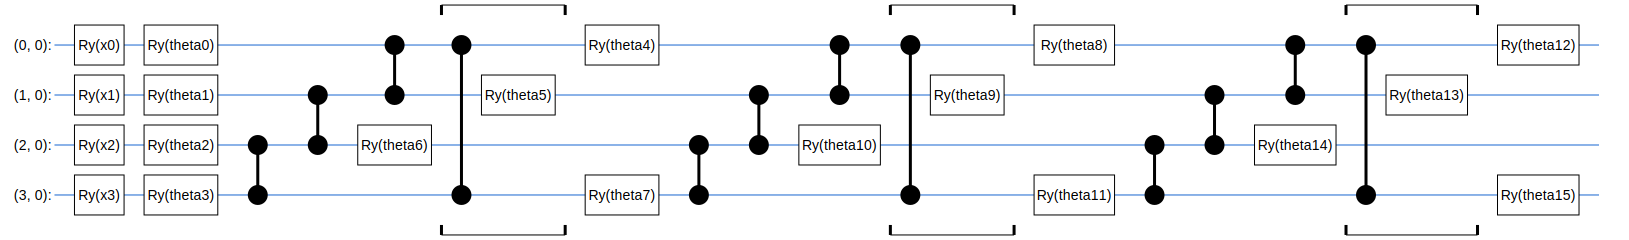

In [7]:
SVGCircuit(model.EdgeNet.model_circuit)

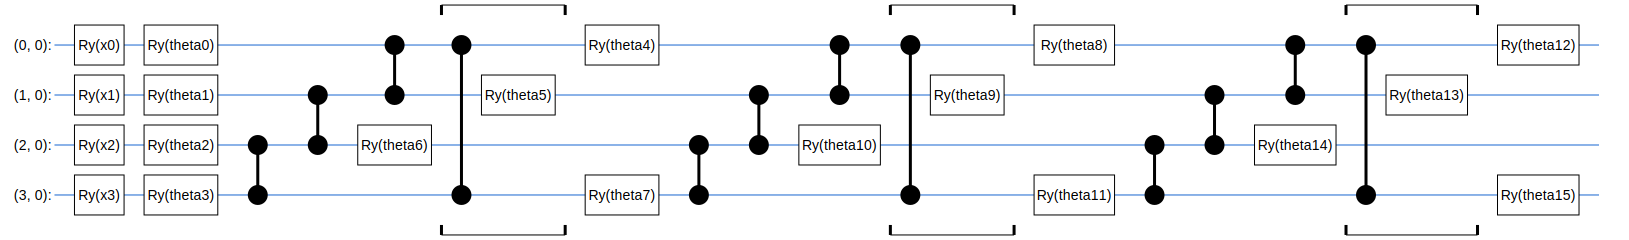

In [8]:
SVGCircuit(model.NodeNet.model_circuit)

In [15]:
initial_params=model.EdgeNet.params
print(initial_params)

<tf.Variable 'Variable:0' shape=(1, 16) dtype=float32, numpy=
array([[1.2840116 , 6.259226  , 4.592669  , 5.927728  , 2.6765127 ,
        1.4148434 , 0.31373954, 3.9064088 , 1.3186707 , 1.3258561 ,
        1.0584819 , 5.0238853 , 5.4778686 , 0.8245559 , 5.983012  ,
        2.172463  ]], dtype=float32)>


In [16]:
model([map2angle(X_test), Ri_test, Ro_test])

<tf.Tensor: shape=(10673, 1), dtype=float32, numpy=
array([[0.40951154],
       [0.42062593],
       [0.4095669 ],
       ...,
       [0.39126736],
       [0.42539468],
       [0.38746244]], dtype=float32)>

In [17]:
model.EdgeNet.params

<tf.Variable 'Variable:0' shape=(1, 16) dtype=float32, numpy=
array([[1.2840116 , 6.259226  , 4.592669  , 5.927728  , 2.6765127 ,
        1.4148434 , 0.31373954, 3.9064088 , 1.3186707 , 1.3258561 ,
        1.0584819 , 5.0238853 , 5.4778686 , 0.8245559 , 5.983012  ,
        2.172463  ]], dtype=float32)>

In [18]:
(model.trainable_variables)

[<tf.Variable 'GNN/InputNet/kernel:0' shape=(3, 4) dtype=float32, numpy=
 array([[-0.13783038, -0.03880394, -0.61459756, -0.39968383],
        [-0.38154137,  0.65037763,  0.79290175, -0.40675366],
        [ 0.6019714 , -0.05791521, -0.25345856, -0.76330894]],
       dtype=float32)>,
 <tf.Variable 'GNN/InputNet/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1, 16) dtype=float32, numpy=
 array([[1.2840116 , 6.259226  , 4.592669  , 5.927728  , 2.6765127 ,
         1.4148434 , 0.31373954, 3.9064088 , 1.3186707 , 1.3258561 ,
         1.0584819 , 5.0238853 , 5.4778686 , 0.8245559 , 5.983012  ,
         2.172463  ]], dtype=float32)>,
 <tf.Variable 'dense_2/kernel:0' shape=(14, 4) dtype=float32, numpy=
 array([[ 0.08548969,  0.32524806,  0.05196214, -0.55681604],
        [-0.30323517, -0.17748973,  0.19112885,  0.32711112],
        [-0.34103537,  0.04974419,  0.45772028, -0.0492785 ],
        [ 0.3753084 , -0.34228224, -0.2987

In [19]:
model.EdgeNet.params

<tf.Variable 'Variable:0' shape=(1, 16) dtype=float32, numpy=
array([[1.2840116 , 6.259226  , 4.592669  , 5.927728  , 2.6765127 ,
        1.4148434 , 0.31373954, 3.9064088 , 1.3186707 , 1.3258561 ,
        1.0584819 , 5.0238853 , 5.4778686 , 0.8245559 , 5.983012  ,
        2.172463  ]], dtype=float32)>

In [20]:
np.shape(Ri_test)

(6217, 10673)

In [21]:
len(dir(EdgeNet))

159

In [22]:
InputNet =  tf.keras.layers.Dense(
            GNN.config['hid_dim'], input_shape=(3,),
            activation='relu',name='InputNet'
        )

In [23]:

# execute InputNet to produce hidden dimensions
H = InputNet(X_test)
# add new dimensions to original X matrix
H = tf.concat([H,X_test],axis=1)


In [24]:
bo = tf.matmul(Ro_test,H,transpose_a=True)
bi = tf.matmul(Ri_test,H,transpose_a=True)

# Shape of B = N_edges x 6 (2x (3 coordinates))
# each row consists of two node that are possibly connected.
B  = tf.concat([bo, bi], axis=1) # n_edges x 6, 3-> r,phi,z 

In [25]:
bi[0]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([ 0.        ,  0.33198527,  0.0964465 ,  0.09474768,  0.03149671,
       -0.41214406,  0.0447477 ], dtype=float32)>

In [26]:
hid_dim=4
layer = tf.keras.Sequential([
            tf.keras.Input(shape=(hid_dim+3)*2,),
            tf.keras.layers.Dense(hid_dim, activation='tanh'),
            tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

In [27]:
np.shape(B)

TensorShape([10673, 14])

In [28]:
e=layer(B)

In [ ]:
e

In [ ]:
Rwo = Ro_test * e[:,0]
Rwi = Ri_test * e[:,0]

In [ ]:
mi = tf.matmul(Rwi, bi)
mo = tf.matmul(Rwo, bo)

In [ ]:
M = tf.concat([mi, mo, X_test], axis=1)

In [ ]:
np.shape(M)

In [ ]:
hid_dim=4
node_layer = tf.keras.Sequential([
            tf.keras.Input(shape=(hid_dim+3)*3,),
            tf.keras.layers.Dense(hid_dim, activation='tanh'),
            tf.keras.layers.Dropout(.2, input_shape=(hid_dim,)),
            tf.keras.layers.Dense(hid_dim, activation='sigmoid'),
        ])

In [ ]:

bo  = tf.matmul(Ro_test, H, transpose_a=True)
bi  = tf.matmul(Ri_test, H, transpose_a=True) 
Rwo = Ro_test * e[:,0]
Rwi = Ri_test * e[:,0]

# changin the order to test something !!!!!!!!! DONT FORGET TO LOOK BACK!!!
mi = tf.matmul(Rwi, bo)
mo = tf.matmul(Rwo, bi)
# Shape of M = N_nodes x 9 (3x (3 coordinates))
# each row consists of a node and its 2 possible neigbours
M = tf.concat([mi, mo, H], axis=1)

node_layer(M)

In [ ]:
H[0]

In [ ]:
M[0]

In [ ]:
-0.808/-0.136

In [ ]:
np.shape(mo)

In [ ]:
np.shape(M)

In [ ]:
EdgeNet  = EdgeNet(name='EdgeNet')

In [ ]:
initial_params=EdgeNet.params

In [ ]:
Trained_EdgeNet=EdgeNet(H, Ri_test, Ro_test)

In [ ]:
Trained_EdgeNet

In [ ]:
initial_params

In [ ]:
model_test=GNN()

In [ ]:
circuit= cirq.Circuit()
qubits  = cirq.GridQubit.rect(n_qubits, 1)
n_layers=1
n_qubits=4
symbol_offset=0
params = sympy.symbols('theta{}:{}'.format(symbol_offset, symbol_offset + n_qubits*(1+n_layers)))

In [ ]:
qc = QCircuit(IEC_id='simple_encoding_y',
            PQC_id='10',
            MC_id='measure_all',
            n_layers=n_layers, 
            input_size=n_qubits,
            p=0.01)
qc_2= QCircuit(IEC_id='simple_encoding_y',
            PQC_id='10nocz',
            MC_id='measure_all',
            n_layers=n_layers, 
            input_size=n_qubits,
            p=0.01)

In [ ]:
(qc.model_circuit())

In [ ]:
qc_2.model_circuit()

In [ ]:
model_test.EdgeNet.model_circuit=qc_2.model_circuit()[0]

In [ ]:
model_test(X_test,Ri_test,Ro_test,y_test)

In [ ]:
train_files=os.listdir('/Users/lucascurtin/Desktop/edge_data/train_graphs')
valid_files=os.listdir('/Users/lucascurtin/Desktop/edge_data/valid_graphs')

In [ ]:

fake_edges=0
true_edges=0
all_edges=0
for i in range(len(train_files)):
    if train_files[i]!='.DS_Store':
        dir='/Users/lucascurtin/Desktop/edge_data/train_graphs/{}'.format(train_files[i])
        X_f, Ri_f, Ro_f, y_f = load_graph(dir)
        fake_edges+=y_f.tolist().count(0)
        true_edges+=y_f.tolist().count(1)
        all_edges+=len(y_f)
        print(i)
    
for i in range(len(valid_files)):
    if valid_files[i]!='.DS_Store':
        dir='/Users/lucascurtin/Desktop/edge_data/valid_graphs/{}'.format(valid_files[i])
        X_f, Ri_f, Ro_f, y_f = load_graph(dir)
        fake_edges+=y_f.tolist().count(0)
        true_edges+=y_f.tolist().count(1)
        all_edges+=len(y_f)
        print(i)


In [ ]:
y_f.tolist().count(0)

In [ ]:
train_files[16]

In [ ]:
fake_edges,true_edges,all_edges

In [12]:
class Rescale01(tf.keras.layers.Layer):
    def __init__(self, name='Rescale01'):
        super(Rescale01, self).__init__(name=name)

    def call(self, X):
        X = tf.divide(
                tf.subtract(
                    X, 
                    tf.reduce_min(X)
                ), 
                tf.subtract(
                    tf.reduce_max(X), 
                    tf.reduce_min(X)
                ),
            lambda: X
        )
        return X

In [13]:
input_layer = tf.keras.Sequential([
            tf.keras.layers.Dense(
                4, 
                activation='relu'),
            Rescale01()
        ])

In [29]:
input_to_circuit = input_layer(B) * np.pi

        # Combine input data with parameters in a single circuit_data matrix
circuit_data = tf.concat(
    [
        input_to_circuit, 
        tf.repeat(20,repeats=input_to_circuit.shape[0],axis=0)
    ],
    axis=1
)        


InvalidArgumentError: cannot compute ConcatV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:ConcatV2] name: concat